# Outcome-informed Love plot

In [2]:
%config InlineBackend.figure_format = "svg"

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import matplotlib as mpl
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.special import expit

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from causallib.estimation import IPW


In [4]:
def generate_data(n=1000, seed=0):
    rng = np.random.default_rng(seed)
    
    X = rng.normal(0, 0.5, size=(n, 4))
    a_beta = np.array([0, 1, 0, 1])
    a_logit = X @ a_beta
    a_prop = expit(a_logit)
    a = rng.binomial(1, a_prop)

    y_beta = np.array([0, 0, -1, -1])
    effect = 1
    y = X @ y_beta + a * effect + rng.normal(0, 1, size=n)
    
    X = pd.DataFrame(X, columns=["x0", "xa", "xy", "xay"])
    a = pd.Series(a, name="a")
    y = pd.Series(y, name="y")
    return X, a, y

In [5]:
X, a, y = generate_data()
X.join(a).join(y)

,x0,xa,xy,xay,a,y
0,0.062865,-0.066052,0.320211,0.052450,1,1.477364
1,-0.267835,0.180798,0.652000,0.473540,0,-1.847662
2,-0.351868,-0.632711,-0.311637,0.020663,0,0.689057
3,-1.162515,-0.109396,-0.622955,-0.366134,0,1.917618
4,-0.272129,-0.158150,0.205815,0.521257,1,-1.060988
...,...,...,...,...,...,...
995,-0.450861,1.003341,0.823907,-0.154471,1,1.280002
996,-0.827534,-0.510914,-0.101346,-0.120888,1,2.251462
997,0.859242,-0.639025,-0.057299,-0.096433,1,1.472600
998,0.411003,-0.116951,-0.140148,-0.009453,0,1.207335


In [6]:
ipw = IPW(LogisticRegression(penalty="none"))
ipw.fit(X, a)
w = ipw.compute_weights(X, a)

In [7]:
def calculate_asmd(X, a, w=None):
    eps = np.finfo(X.dtypes.iloc[0]).resolution  # .eps
    if w is None:
        w = pd.Series(1, index=a.index)
    
    is_treated = a == 1
    x1 = sm.stats.DescrStatsW(X.loc[is_treated], weights=w.loc[is_treated])
    x0 = sm.stats.DescrStatsW(X.loc[~is_treated], weights=w.loc[~is_treated])

    x1_mean = pd.Series(x1.mean, index=X.columns)
    x0_mean = pd.Series(x0.mean, index=X.columns)
    x1_var = pd.Series(x1.var, index=X.columns)
    x0_var = pd.Series(x0.var, index=X.columns)

    smds = (x1_mean - x0_mean) / np.sqrt(x0_var + x1_var + eps)
    asmds = smds.abs()
    asmds.name = "asmd"
    return asmds

In [8]:
asmds = pd.concat({
    "weighted": calculate_asmd(X, a, w),
    "unweighted": calculate_asmd(X, a),
}, names=["adjustment", "covariate"])
asmds

adjustment  covariate
weighted    x0           0.002535
            xa           0.001482
            xy           0.000966
            xay          0.002014
unweighted  x0           0.015296
            xa           0.314791
            xy           0.053678
            xay          0.209638
Name: asmd, dtype: float64

In [9]:
def leave_one_out_importance(estimator, X, a, y):
    results = []

    for col in ["full"] + X.columns.tolist():
        curX = X.drop(columns=col, errors="ignore")
        curXa = curX.join(a)
        estimator.fit(curXa, y)
        y_pred = estimator.predict(curXa)
        result = {
            "covariate": col,
            "r2": r2_score(y, y_pred),
            "mse": mean_squared_error(y, y_pred),
            "mae": mean_absolute_error(y, y_pred),
        }
        results.append(result)
    results = pd.DataFrame(results)
    return results

def relative_explained_variation(estimator, X, a, y, metric="mse"):
    """Harrell: https://www.fharrell.com/post/addvalue/"""
    importance = leave_one_out_importance(estimator, X, a, y)
    importance = importance.set_index("covariate")
    importance = importance / importance.loc["full"]
    importance = importance.drop(index="full")
    # importance = importance[metric]
    return importance

def decrease_in_explain_variation(estimator, X, a, y, metric="mse"):
    """https://stackoverflow.com/q/31343563"""
    importance = leave_one_out_importance(estimator, X, a, y)
    importance = importance.set_index("covariate")
    importance = (importance.loc["full"]-importance) / importance.loc["full"]
    importance = importance.drop(index="full")
    # importance = importance[metric]
    importance = importance.abs()
    return importance


In [10]:
# i = leave_one_out_importance(LinearRegression(), X, a, y)
# i = i.set_index("covariate")
# i
# relative_explained_variation(LinearRegression(), X, a, y)
feature_importance = decrease_in_explain_variation(LinearRegression(), X, a, y)
feature_importance

,r2,mse,mae
covariate,,,
x0,0.000356,0.000235,0.000600
xa,0.000038,0.000025,0.000139
xy,0.402544,0.266615,0.123345
xay,0.340198,0.225322,0.113050


In [11]:
plot_data = asmds.reset_index().merge(
    feature_importance.reset_index(), on="covariate",
)
plot_data

,adjustment,covariate,asmd,r2,mse,mae
0,weighted,x0,0.002535,0.000356,0.000235,0.000600
1,weighted,xa,0.001482,0.000038,0.000025,0.000139
2,weighted,xy,0.000966,0.402544,0.266615,0.123345
3,weighted,xay,0.002014,0.340198,0.225322,0.113050
4,unweighted,x0,0.015296,0.000356,0.000235,0.000600
5,unweighted,xa,0.314791,0.000038,0.000025,0.000139
6,unweighted,xy,0.053678,0.402544,0.266615,0.123345
7,unweighted,xay,0.209638,0.340198,0.225322,0.113050


In [12]:
# Prettify covariate names:
plot_data = plot_data.replace({
    "covariate": {
        "x0": "$X_0$",
        "xa": "$X_A$",
        "xy": "$X_Y$",
        "xay": "$X_{AY}$",
    },
})

In [13]:
def ouilove_plot(
    dot_plot_data, 
    plot_range=False, 
    order_by_importance=False,
    opacity=False,
    pointsize=False,
    importance_metric="mse",
    legend=True,
    threshold=None, ax=None,
):
    order_by = importance_metric if order_by_importance else "asmd"
    y_order = dot_plot_data.query("adjustment=='unweighted'").sort_values(order_by, ascending=False)["covariate"].tolist()
    
    p = so.Plot(
    ).add(
        so.Dot(), 
        y="covariate",
        x="asmd",
        color="adjustment", marker="adjustment",
        pointsize=importance_metric if pointsize else None,
        alpha=importance_metric if opacity else None,
        legend=legend,
        data=dot_plot_data,
    ).scale(
        marker=dict(weighted="o", unweighted="^"),
        y=so.Nominal(order=y_order),
    ).label(
        x="Absolute standardized mean difference",
        y="Covariate",
    ).theme(
        sns.axes_style("white")
    )

    if plot_range:
        range_plot_data = dot_plot_data.pivot(
            columns="adjustment", index="covariate", values="asmd"
        ).agg(["min", "max"], axis="columns").merge(
            dot_plot_data.query("adjustment=='unweighted'"),
            on="covariate",
        )
        p = p.add(
            so.Range(linestyle="--", color="0.8", artist_kws=dict(zorder=0)), 
            y="covariate",
            xmin="min", xmax="max",
            linewidth=importance_metric if pointsize else None,
            alpha=importance_metric if opacity else None,
            legend=legend,
            data=range_plot_data,
        )
    if threshold is not None:
        ax.axvline(0.1, linestyle="--", color="0.6", zorder=0)
    if ax is not None:
        p = p.on(ax).plot()
    return p


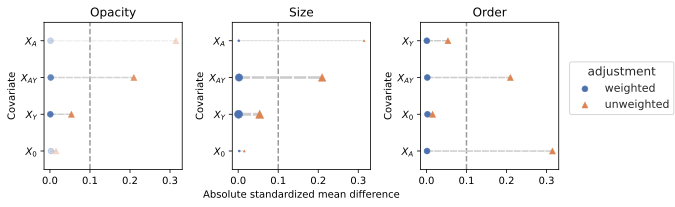

In [14]:
#| label: fig-oui-encoding
#| fig-cap: >
#|   Encoding covariate-outcome importance information as marker opacity, marker size, and covariate order.
#|   Opacity and size allow less important covariates to appear more salient by making them more transparent or smaller, respectively.
#|   Y-axis order moves less important covariates further down the plot, focusing more important covariates in a specific region of the figure.

fig = mpl.figure.Figure(figsize=(8, 3))
axes = fig.subplot_mosaic("BCD")
fig, axes = mpl.pyplot.subplot_mosaic("BCD", figsize=(8, 3))
p = ouilove_plot(
    plot_data, 
    plot_range=True,
    order_by_importance=False,
    opacity=True,
    pointsize=False,
    importance_metric="mse",
    legend=False,
    threshold=0.1, ax=axes["B"],
)
axes["B"].set_title("Opacity")
p = ouilove_plot(
    plot_data, 
    plot_range=True,
    order_by_importance=True,
    opacity=False,
    pointsize=False,
    importance_metric="mse",
    legend=True,
    threshold=0.1, ax=axes["D"],
)
axes["D"].set_title("Order")
p = ouilove_plot(
    plot_data, 
    plot_range=True,
    order_by_importance=False,
    opacity=False,
    pointsize=True,
    importance_metric="mse",
    legend=False,
    threshold=0.1, ax=axes["C"],
)
axes["C"].set_title("Size")
axes["B"].set_xlabel(None)
axes["D"].set_xlabel(None)
# fig.suptitle(
#     "Visual channels to incorporate outcome information",
# )
fig.tight_layout()
# fig

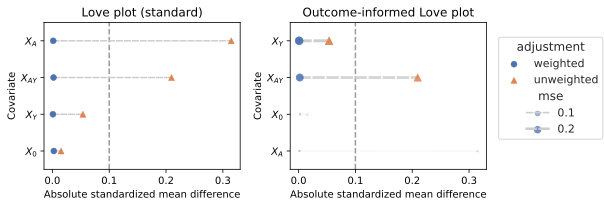

In [15]:
#| label: fig-love-oui-love
#| fig-cap: >
#|   Outcome-informed Love plot.
#|   On the left, a standard Love plot, 
#|   showing covariates on the y-axis sorted by unadjusted ASMD, 
#|   ASMD on the x-axis, 
#|   unadjusted ASMDs as orange triangle and inverse propensity weighted ASMDs as blue circles. 
#|   On the right, an Outcome-informed Love plot, encoding the importance of covariate on outcome prediction 
#|   in three different visual channels: 
#|   size (less important covariates are smaller), opacity(less important covariates are more transparent),
#|   and y-axis order (less important covariates are further down the panel).
#|   Outcome-informed Love plots reduce clutter and highlight the more important covariates to which examine balancing on. 


fig = mpl.figure.Figure(figsize=(7, 3))
axes = fig.subplot_mosaic("AE", sharex=True)
fig, axes = mpl.pyplot.subplot_mosaic("AE", figsize=(7, 3), sharex=True)
p = ouilove_plot(
    plot_data, 
    plot_range=True,
    order_by_importance=False,
    opacity=False,
    pointsize=False,
    importance_metric="mse",
    legend=False,
    threshold=0.1, ax=axes["A"],
)
axes["A"].set_title("Love plot (standard)")

p = ouilove_plot(
    plot_data, 
    plot_range=True,
    order_by_importance=True,
    opacity=True,
    pointsize=True,
    importance_metric="mse",
    legend=True,
    threshold=0.1, ax=axes["E"],
)
axes["E"].set_title("Outcome-informed Love plot")
fig.tight_layout()
# fig

## Combinging ASMD and FI in a single metric to allow selection

In [16]:
ouiasmd = plot_data.query("adjustment=='unweighted'").drop(columns="adjustment")
ouiasmd

,covariate,asmd,r2,mse,mae
4,$X_0$,0.015296,0.000356,0.000235,0.000600
5,$X_A$,0.314791,0.000038,0.000025,0.000139
6,$X_Y$,0.053678,0.402544,0.266615,0.123345
7,$X_{AY}$,0.209638,0.340198,0.225322,0.113050


In [17]:
outcome_metric = "mse"
ouiasmd["ouiasmd"] = ouiasmd["asmd"] * ouiasmd[outcome_metric]
ouiasmd

,covariate,asmd,r2,mse,mae,ouiasmd
4,$X_0$,0.015296,0.000356,0.000235,0.000600,0.000004
5,$X_A$,0.314791,0.000038,0.000025,0.000139,0.000008
6,$X_Y$,0.053678,0.402544,0.266615,0.123345,0.014311
7,$X_{AY}$,0.209638,0.340198,0.225322,0.113050,0.047236


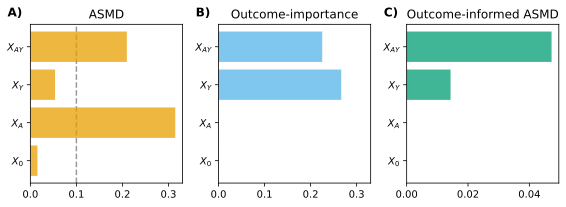

In [18]:
#| label: fig-oui-asmd-score
#| fig-cap: >
#|   Outcome-informed ASMD score.
#|   A) Inverse propensity weighted ASMD, with 0.1 threshold reference (dashed)
#|   B) Covariate-outcome importance score (mean decrease in mean square error).
#|   C) Outcome-informed ASMD, generated by multiplying the above two. 
#|   The ASMD emphasizes covariate-exposure associations ($X_A, X_{AY}$),
#|   the outcome-importance score emphasizes covariate-outcome associations ($X_Y, X_{AY}$),
#|   and outcome-informed ASMD emphasizes the interaction of the former two scores ($X_{AY}$).  

# fig = mpl.figure.Figure(figsize=(8, 3))
fig, axes = mpl.pyplot.subplot_mosaic(
    """
    ABC
    """,
    # sharey=True,
    figsize=(8,3)
)
bar_kwargs = {"alpha": 0.75}
axes["A"].barh(ouiasmd["covariate"], ouiasmd["asmd"], color="#E69F00", **bar_kwargs)
axes["B"].barh(ouiasmd["covariate"], ouiasmd[outcome_metric], color="#56B4E9", **bar_kwargs)
axes["C"].barh(ouiasmd["covariate"], ouiasmd["ouiasmd"], color="#009E73", **bar_kwargs)
axes["A"].axvline(0.1, linestyle="--", color="0.6", zorder=0)
axes["A"].sharex(axes["B"])
axes["C"].xaxis.set_major_locator(mpl.pyplot.MaxNLocator(3))
axes["A"].set_title("ASMD")
axes["B"].set_title("Outcome-importance")
axes["C"].set_title("Outcome-informed ASMD")
for letter, ax in axes.items():
    ax.text(
        -0.15, 1.05,
        f"{letter})",
        fontweight="bold",
        fontsize=12,
        transform=ax.transAxes,
)
fig.tight_layout()


#### Love plot by Oui-ASMD score

In [28]:
# outcome_metric = "mse"
# ouiasmd_plot_data = plot_data.assign(
#     ouiasmd=plot_data["asmd"] * plot_data[outcome_metric]
# )
ouiasmd_plot_data = plot_data.merge(
    ouiasmd[["covariate", "ouiasmd"]],
    on="covariate",
    how="left",
)

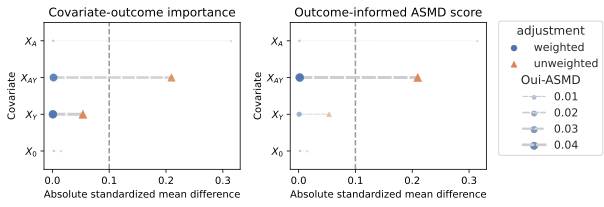

In [33]:
#| label: fig-ouiasmd-love
#| fig-cap: >
#|   Love plot augmented by outcome-informed ASMD.
#|   On the left, an outcome-informed Love plot augmented by covariate-outcome importance
#|   (Similar to @fig-love-oui-love, right, but without ordering). 
#|   On the right, an outcome-informed Love plot, but augmented by the combined outcome-importance ASMD score.
#|   While the former may emphasize prognostic variables too much ($X_Y$),
#|   the latter is able to minimize their importance and emphasize instead confounding variables
#|   that have both larger covariate-outcome importance *and* have large ASMD.


fig = mpl.figure.Figure(figsize=(7, 3))
axes = fig.subplot_mosaic("AE", sharex=True)
fig, axes = mpl.pyplot.subplot_mosaic("AE", figsize=(7, 3), sharex=True, sharey=True)
p = ouilove_plot(
    ouiasmd_plot_data.rename(columns={"ouiasmd": "Oui-ASMD"}), 
    plot_range=True,
    order_by_importance=False,
    opacity=True,
    pointsize=True,
    importance_metric="mse",
    legend=False,
    threshold=0.1, ax=axes["A"],
)
axes["A"].set_title("Covariate-outcome importance")

p = ouilove_plot(
    ouiasmd_plot_data.rename(columns={"ouiasmd": "Oui-ASMD"}), 
    plot_range=True,
    order_by_importance=False,
    opacity=True,
    pointsize=True,
    importance_metric="Oui-ASMD",
    legend=True,
    threshold=0.1, ax=axes["E"],
)
axes["E"].set_title("Outcome-informed ASMD score")
fig.tight_layout()
# fig

Also comparing to standard Love plot:

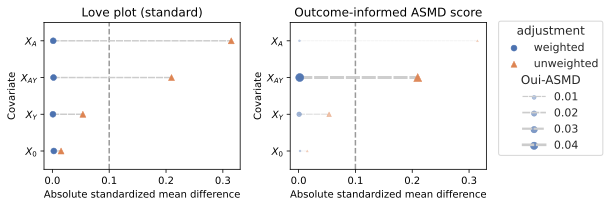

In [38]:
#| label: fig-ouiasmd-love
#| fig-cap: >
#|   Love plot augmented by outcome-informed ASMD.
#|   On the left, an outcome-informed Love plot augmented by covariate-outcome importance
#|   (Similar to @fig-love-oui-love, right, but without ordering). 
#|   On the right, an outcome-informed Love plot, but augmented by the combined outcome-importance ASMD score.
#|   While the former may emphasize prognostic variables too much ($X_Y$),
#|   the latter is able to minimize their importance and emphasize instead confounding variables
#|   that have both larger covariate-outcome importance *and* have large ASMD.


fig = mpl.figure.Figure(figsize=(7, 3))
axes = fig.subplot_mosaic("AE", sharex=True)
fig, axes = mpl.pyplot.subplot_mosaic("AE", figsize=(7, 3), sharex=True, sharey=True)
p = ouilove_plot(
    plot_data, 
    plot_range=True,
    order_by_importance=False,
    opacity=False,
    pointsize=False,
    importance_metric="mse",
    legend=False,
    threshold=0.1, ax=axes["A"],
)
axes["A"].set_title("Love plot (standard)")

p = ouilove_plot(
    ouiasmd_plot_data.rename(columns={"ouiasmd": "Oui-ASMD"}), 
    plot_range=True,
    order_by_importance=False,
    opacity=True,
    pointsize=True,
    importance_metric="Oui-ASMD",
    legend=True,
    threshold=0.1, ax=axes["E"],
)
axes["E"].set_title("Outcome-informed ASMD score")
fig.tight_layout()
# fig